# MP 1
### Emmanuel Gallegos
### CS 543: Computer Vision
### Prof. Svetlana Lazebnik
### University of Illinois Urbana Champaign

In [1]:
import time
import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [143]:
# useful constants
UP=0
RIGHT=1
DOWN=2
LEFT=3

BLUE=0
GREEN=1
RED=2

COLOR_1 = RED
COLOR_2 = GREEN
COLOR_DEF = BLUE

WINDOW_SIZE = 15
CROP_AMOUNT = 50

WINDOW_SIZE_HIRES = 100

In [142]:
# set image paths
basic_img_dir = os.path.join(os.getcwd(), "data")
hires_img_dir = os.path.join(os.getcwd(), "data_hires")
basic_img_paths = [os.path.join(basic_img_dir, img_path) for img_path in os.listdir(basic_img_dir)]
hires_img_paths = [os.path.join(hires_img_dir, img_path) for img_path in os.listdir(hires_img_dir)]
# make directory for colorized photos if it does not exist
basic_colorized_dir = os.path.join(basic_img_dir, "..", "basic_colorized")
hires_colorized_dir = os.path.join(hires_img_dir, "..", "hires_colorized")
if not os.path.exists(basic_colorized_dir):
    os.mkdir(basic_colorized_dir)
if not os.path.exists(hires_colorized_dir):
    os.mkdir(hires_colorized_dir)
basic_colorized_paths = [os.path.join(basic_colorized_dir, img_path) for img_path in os.listdir(basic_img_dir)]
hires_colorized_paths = [os.path.join(hires_colorized_dir, img_path) for img_path in os.listdir(hires_img_dir)]
print(basic_img_paths)
print(hires_img_paths)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(basic_colorized_paths)
print(hires_colorized_paths)

['C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\00125v.jpg', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\00149v.jpg', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\00153v.jpg', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\00351v.jpg', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\00398v.jpg', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data\\01112v.jpg']
['C:\\Users\\oh_bo\\Documents\\UIUC\\Fall_2022\\ComputerVision\\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\\data_hires\\01047u.tiff', 'C:\\Users\\oh_bo\\Documents\\UIUC\\Fal

## Function definitions

In [133]:
# roll a 2d image in a given direction (0->up, 1->right, 2->down, 3->left)
def roll_image(image, direction, n_pixels):
    if direction == UP:
        return np.roll(image, -n_pixels, axis=0)
    elif direction == DOWN:
        return np.roll(image, n_pixels, axis=0)
    elif direction == RIGHT:
        return np.roll(image, n_pixels, axis=1)
    elif direction == LEFT:
        return np.roll(image, -n_pixels, axis=1)

# takes array of 3 grayscale images and normalizes each one to mean 0, unit norm
def normalize_image(bgr_image):
    # save shape of channel
    original_shape = bgr_image.shape
    # unroll the channels to 1d arrays
    unrolled_channels = bgr_image.reshape(3,-1)
    # get channel means
    means = np.mean(unrolled_channels, axis=1).reshape(-1,1)
    # subtract channel means to get mean 0 channels
    mean_0_channels = unrolled_channels - means
    # get channel norms
    norms = np.linalg.norm(mean_0_channels, axis=1).reshape(-1,1)
    # normalize channels
    norm_channels = mean_0_channels / norms  
    # reshape normalized arrays to original shape
    return norm_channels.reshape(original_shape)
    
# returns alignment indices (row, col) for normalized grayscale images
def get_alignment_indices(norm_channels):    
    # fit alignment of color1 and color2 channels to default color channel through exhaustive search
    best_col_1_val, best_col_2_val = 0, 0
    best_col_1_disp = (0,0)
    best_col_2_disp = (0,0)
    # roll color1 and color2 images up and to the left by 15 pixels
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], UP, WINDOW_SIZE)
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], UP, WINDOW_SIZE)
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], LEFT, WINDOW_SIZE)
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], LEFT, WINDOW_SIZE)
    # exhaustively search for best alignment
    # iterate over columns
    for col in range(-WINDOW_SIZE, WINDOW_SIZE+1):
        # iterate over rows
        for row in range(-WINDOW_SIZE, WINDOW_SIZE+1):
            # crop image (to avoid comparing wonky rolled borders)
            cropped_channels = norm_channels[:,CROP_AMOUNT:-CROP_AMOUNT,CROP_AMOUNT:-CROP_AMOUNT]
            # unroll
            unrolled_channels = cropped_channels.reshape(3,-1)
            # check color1's fit to color default
            color_1_fit = np.correlate(unrolled_channels[COLOR_1], unrolled_channels[COLOR_DEF]) #np.dot(norm_channels[COLOR_1], norm_channels[COLOR_DEF])
            # check color2's fit to color default
            color_2_fit = np.correlate(unrolled_channels[COLOR_2], unrolled_channels[COLOR_DEF]) #np.dot(norm_channels[COLOR_2], norm_channels[COLOR_DEF])
            # reroll
            #norm_channels = norm_channels.reshape(original_shape)     
            # update best displacements if needed
            if(color_1_fit > best_col_1_val):
                best_col_1_val = color_1_fit
                best_col_1_disp = (row,col)
            if(color_2_fit > best_col_2_val):
                best_col_2_val = color_2_fit
                best_col_2_disp = (row,col)
            # roll color1 and color2 images down 1 pixel
            norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], DOWN, 1)
            norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], DOWN, 1)
        # roll color1 and color2 images back up to top of window search area
        norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], UP, 2 * WINDOW_SIZE + 1)
        norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], UP, 2 * WINDOW_SIZE + 1)
        # roll color1 and color2 images to right by 1 pixel
        norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], RIGHT, 1)
        norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], RIGHT, 1)           
    
    # print displacement
    print("best color 1 displacement: " + str(best_col_1_disp))
    print("best color 2 displacement: " + str(best_col_2_disp))
    
    return (best_col_1_disp, best_col_2_disp)

# performs actual alignment of 3 grayscale images into rgb image based on best displacements for two colors
def align_image(bgr_image, best_col_1_disp, best_col_2_disp):    
    # roll original color 1 and color 2 images to optimal displacements
    bgr_image[COLOR_1] = roll_image(bgr_image[COLOR_1], DOWN, best_col_1_disp[0])
    bgr_image[COLOR_1] = roll_image(bgr_image[COLOR_1], RIGHT, best_col_1_disp[1])
    bgr_image[COLOR_2] = roll_image(bgr_image[COLOR_2], DOWN, best_col_2_disp[0])
    bgr_image[COLOR_2] = roll_image(bgr_image[COLOR_2], RIGHT, best_col_2_disp[1])
    # change stride from (3,r,c) to (r,c,3)
    bgr_image = bgr_image.transpose(1,2,0)
    # flip channels from bgr to rgb channels
    rgb_image = np.flip(bgr_image, axis=-1)
    
    return rgb_image

## Part 1

C:\Users\oh_bo\Documents\UIUC\Fall_2022\ComputerVision\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\data\00125v.jpg
best color 1 displacement: (12, 1)
best color 2 displacement: (6, 2)
C:\Users\oh_bo\Documents\UIUC\Fall_2022\ComputerVision\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\data\00149v.jpg
best color 1 displacement: (11, 2)
best color 2 displacement: (5, 2)
C:\Users\oh_bo\Documents\UIUC\Fall_2022\ComputerVision\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\data\00153v.jpg
best color 1 displacement: (15, 5)
best color 2 displacement: (8, 3)
C:\Users\oh_bo\Documents\UIUC\Fall_2022\ComputerVision\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\data\00351v.jpg
best color 1 displacement: (15, 1)
best color 2 displacement: (5, 1)
C:\Users\oh_bo\Documents\UIUC\Fall_2022\ComputerVision\Colorizing-Prokudin-Gorskii-Images-of-Russian-empire\data\00398v.jpg
best color 1 displacement: (13, 4)
best color 2 displacement: (6, 3)
C:\Users\oh_bo\Documents\UIUC\Fall_

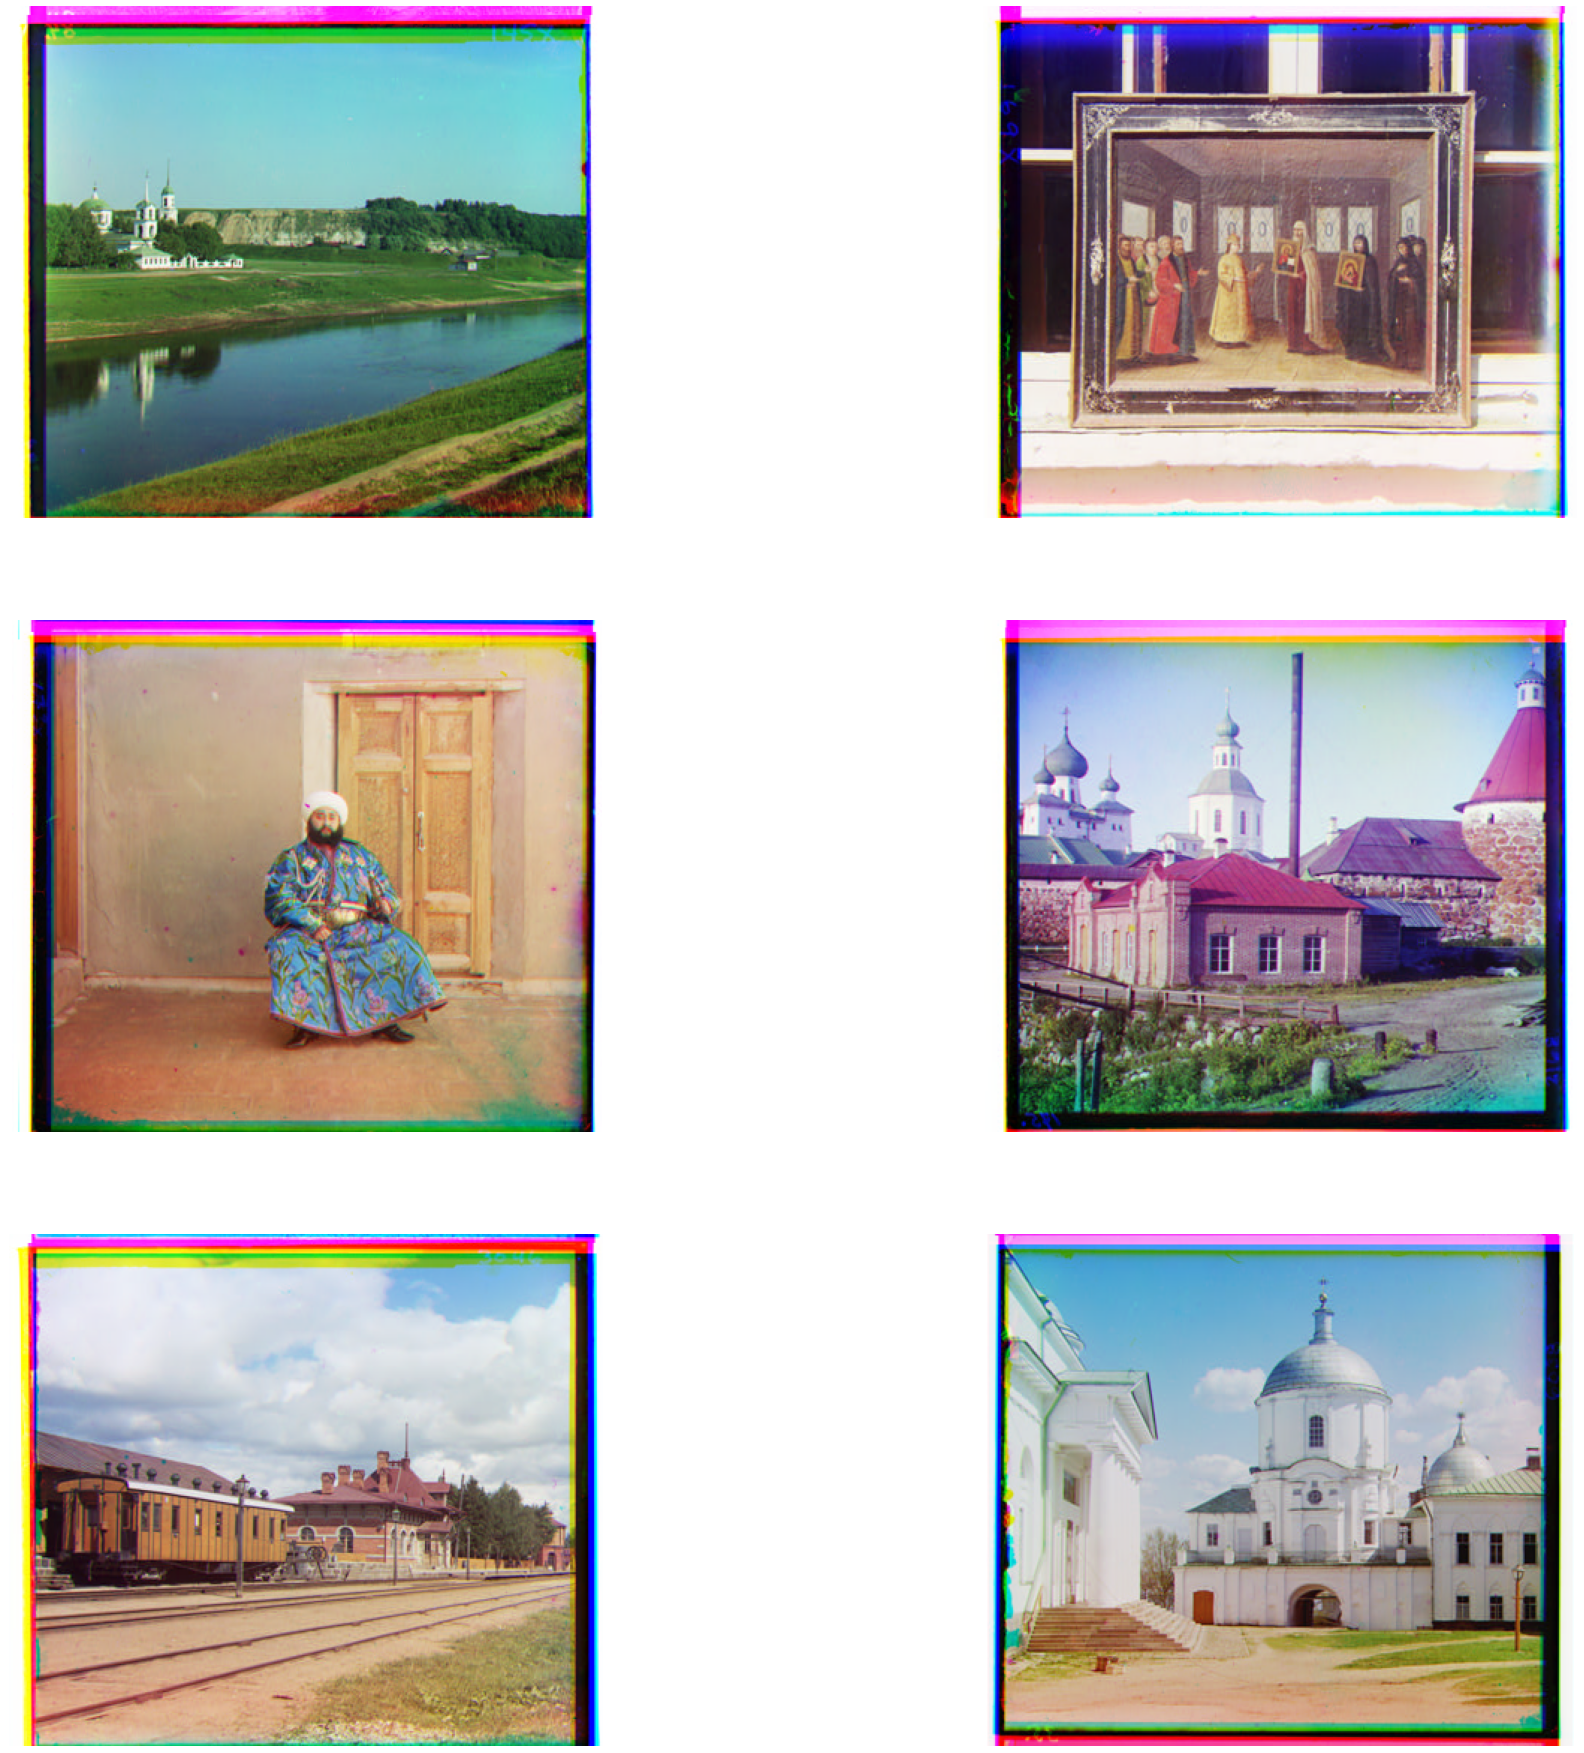

In [134]:
 # create figure
fig = plt.figure(figsize=(32, 32))
rows = 3
columns = 2

for n in range (0,len(basic_img_paths)): 
    print(basic_img_paths[n])
    # open image
    image = Image.open(basic_img_paths[n])
    grayscale_img = image.convert("L")
    # image to numpy array
    np_img = np.array(image)
    # ensure n_rows is multiple of 3
    while np_img.shape[0] % 3 != 0:
        np_img = np.pad(np_img, ((0,1),(0,0)), mode='constant', constant_values=255)
    # get 3 channel images
    bgr_channels = np.array(np.array_split(np_img, 3))
    # normalize images
    norm_channels = normalize_image(bgr_channels)
    # get alignment indices
    alignment_indices = get_alignment_indices(norm_channels)
    # align image
    rgb_image = align_image(bgr_channels, alignment_indices[0], alignment_indices[1])
    # display image
    fig.add_subplot(rows, columns, n+1)
    plt.axis('off')
    plt.imshow(rgb_image)
    # save image
    im = Image.fromarray(rgb_image)
    im.save(basic_colorized_paths[n])

## Part 2

(Known correct answer for part 1 from silly cropped method):
best color 1 displacement: (73, 34)
best color 2 displacement: (25, 20)

In [144]:
# returns alignment indices (row, col) for normalized grayscale images
def get_alignment_indices_hires(norm_channels):    
    # fit alignment of color1 and color2 channels to default color channel through exhaustive search
    best_col_1_val, best_col_2_val = 0, 0
    best_col_1_disp = (0,0)
    best_col_2_disp = (0,0)
    # roll color1 and color2 images up and to the left by 15 pixels
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], UP, WINDOW_SIZE_HIRES)
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], UP, WINDOW_SIZE_HIRES)
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], LEFT, WINDOW_SIZE_HIRES)
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], LEFT, WINDOW_SIZE_HIRES)
    # exhaustively search for best alignment
    # iterate over columns
    for col in range(-WINDOW_SIZE_HIRES, WINDOW_SIZE_HIRES+1):
        # iterate over rows
        for row in range(-WINDOW_SIZE_HIRES, WINDOW_SIZE_HIRES+1):
            # crop image (to avoid comparing wonky rolled borders)
            cropped_channels = norm_channels[:,CROP_AMOUNT:-CROP_AMOUNT,CROP_AMOUNT:-CROP_AMOUNT]
            # unroll
            unrolled_channels = cropped_channels.reshape(3,-1)
            # check color1's fit to color default
            color_1_fit = np.correlate(unrolled_channels[COLOR_1], unrolled_channels[COLOR_DEF]) #np.dot(norm_channels[COLOR_1], norm_channels[COLOR_DEF])
            # check color2's fit to color default
            color_2_fit = np.correlate(unrolled_channels[COLOR_2], unrolled_channels[COLOR_DEF]) #np.dot(norm_channels[COLOR_2], norm_channels[COLOR_DEF])
            # reroll
            #norm_channels = norm_channels.reshape(original_shape)     
            # update best displacements if needed
            if(color_1_fit > best_col_1_val):
                best_col_1_val = color_1_fit
                best_col_1_disp = (row,col)
            if(color_2_fit > best_col_2_val):
                best_col_2_val = color_2_fit
                best_col_2_disp = (row,col)
            # roll color1 and color2 images down 1 pixel
            norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], DOWN, 1)
            norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], DOWN, 1)
        # roll color1 and color2 images back up to top of window search area
        norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], UP, 2 * WINDOW_SIZE_HIRES + 1)
        norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], UP, 2 * WINDOW_SIZE_HIRES + 1)
        # roll color1 and color2 images to right by 1 pixel
        norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], RIGHT, 1)
        norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], RIGHT, 1)           
    
    # print displacement
    print("best color 1 displacement: " + str(best_col_1_disp))
    print("best color 2 displacement: " + str(best_col_2_disp))
    
    return (best_col_1_disp, best_col_2_disp)


best color 1 displacement: (73, 34)
best color 2 displacement: (25, 20)
best color 1 displacement: (72, 27)
best color 2 displacement: (50, 6)


ValueError: num must be 1 <= num <= 1, not 2

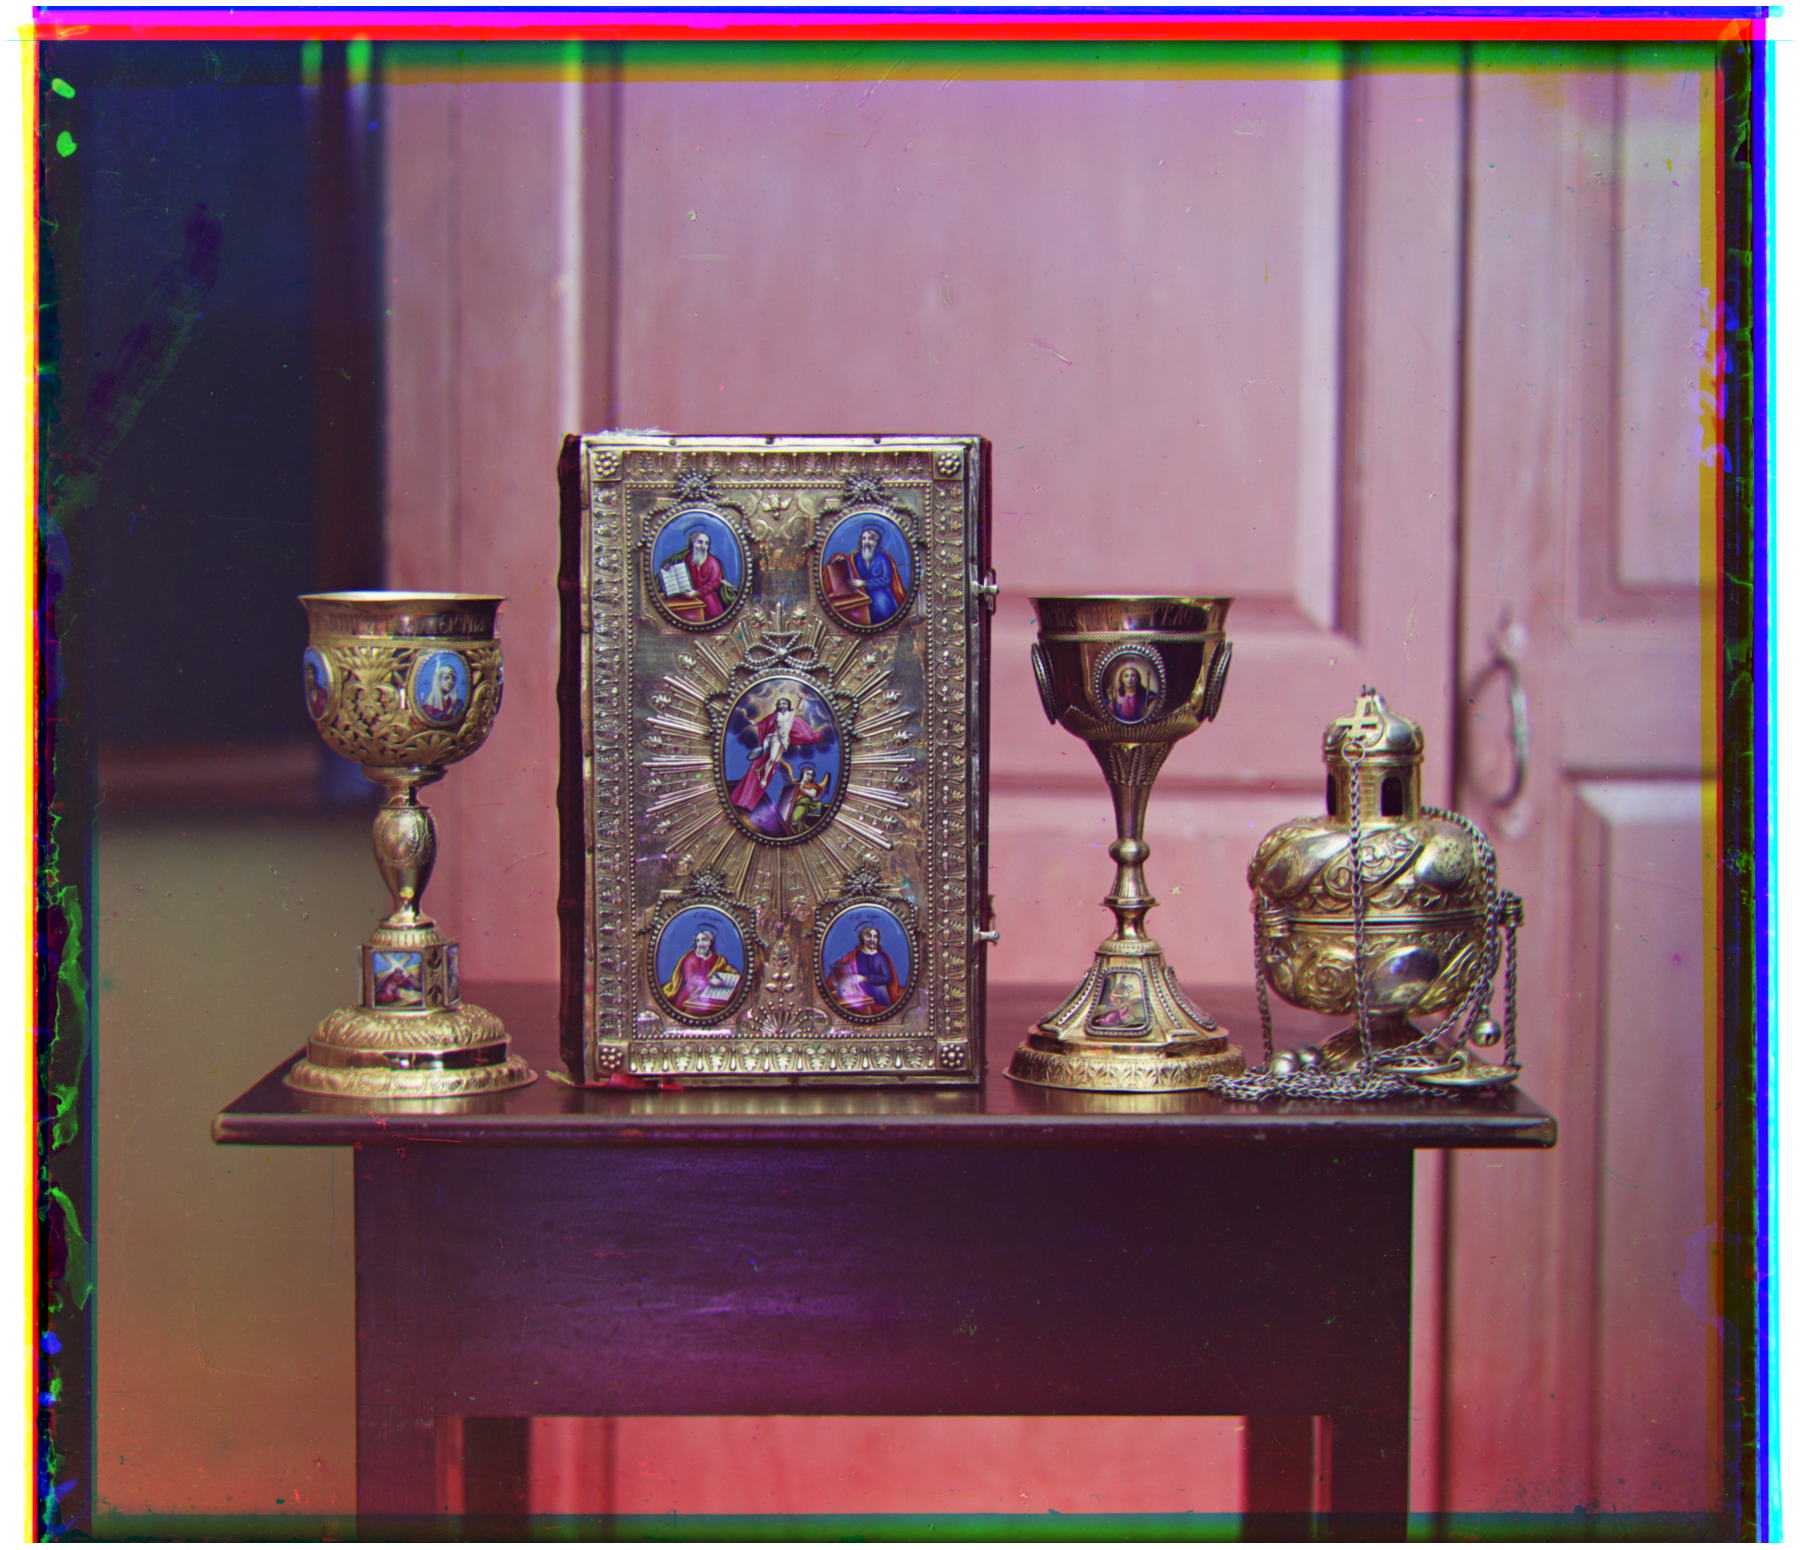

In [148]:
fig = plt.figure(figsize=(32, 32))
rows = 1
columns = 3

Image.MAX_IMAGE_PIXELS = None

for n in range (0, len(hires_img_paths)):
    print(hires_img_paths[n])
    # open image
    image = Image.open(hires_img_paths[n])
    grayscale_img = image.convert("L")
    # image to numpy array
    np_img = np.array(image)
    # ensure n_rows is multiple of 3
    while np_img.shape[0] % 3 != 0:
        np_img = np.pad(np_img, ((0,1),(0,0)), mode='constant', constant_values=0)
    # get 3 channel images
    bgr_channels = np.array(np.array_split(np_img, 3))
    
    # normalize images to between 0 and 1
    max_val = np.max(bgr_channels)
    bgr_channels = bgr_channels / max_val
    
    # silly crop method
    channels, n_rows, n_cols = bgr_channels.shape
    CROP_AMT_ROWS = n_rows // 2 - 200
    CROP_AMT_COLS = n_cols // 2 - 200
    # crop channels 
    cropped_channels = bgr_channels[:, CROP_AMT_ROWS:-CROP_AMT_ROWS, CROP_AMT_COLS:-CROP_AMT_COLS]
    
    # normalize images
    norm_channels = normalize_image(cropped_channels)
    
    # get alignment indices
    alignment_indices = get_alignment_indices_hires(norm_channels)
    # align image
    rgb_image = align_image(bgr_channels, alignment_indices[0], alignment_indices[1])
    # display image
    fig.add_subplot(rows, columns, n+1)
    plt.axis('off')
    plt.imshow(rgb_image)
    # save image
    #im = Image.fromarray(rgb_image)
    #im.save(hires_colorized_paths[n], format="TIFF", save_all=True)